In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import seaborn
import pandas
import numpy


In [3]:

def farenheight_to_celcius(values):
    return (values - 32) * 5/9.0 
    
def load_data(path, resample=None):

    df = pandas.read_csv(path)

    df.columns = [c.strip().removeprefix('AHU: ').removesuffix('Signal').strip() for c in df.columns]
    df['Time'] = pandas.to_datetime(df['Datetime'])
    df = df.drop(columns=['Datetime'])

    df = df.rename(columns={'Occupancy Mode Indicator': 'Occupied', 'Fault Detection Ground Truth': 'Fault'})
    df = df.set_index('Time')
    #df['Fault'] = df.Fault.astype(float)
    for c in df.columns:
        df[c] = df[c].replace({'#VALUE!': None}).astype(numpy.float32)
        if 'Temperature' in c:
            df[c] = farenheight_to_celcius(df[c])

    if resample is not None:
        df = df.resample(resample).agg('median')
        
    return df

path = 'data/SZVAV.csv'
df = load_data(path, resample='10min')
df.head(5)

,Supply Air Temperature,Supply Air Temperature Heating Set Point,Supply Air Temperature Cooling Set Point,Outdoor Air Temperature,Mixed Air Temperature,Return Air Temperature,Supply Air Fan Status,Supply Air Fan Speed Control,Outdoor Air Damper Control,Return Air Damper Control,Exhaust Air Damper Control,Cooling Coil Valve Control,Heating Coil Valve Control,Occupied,Fault
Time,,,,,,,,,,,,,,,
2017-09-11 00:00:00,22.252779,NaN,NaN,27.250002,25.752779,24.647224,1.0,0.1,0.0,1.0,-0.04,0.0,0.245,0.0,1.0
2017-09-11 00:10:00,22.497223,NaN,NaN,27.177778,25.494444,24.527777,1.0,0.1,0.0,1.0,-0.04,0.0,0.215,0.0,1.0
2017-09-11 00:20:00,22.644444,NaN,NaN,27.058334,25.444447,24.461111,1.0,0.1,0.0,1.0,-0.04,0.0,0.205,0.0,1.0
2017-09-11 00:30:00,22.694447,NaN,NaN,26.427778,25.394444,24.424999,1.0,0.1,0.0,1.0,-0.04,0.0,0.200,0.0,1.0
2017-09-11 00:40:00,22.349998,NaN,NaN,25.797222,25.349998,24.377777,1.0,0.1,0.0,1.0,-0.04,0.0,0.240,0.0,1.0


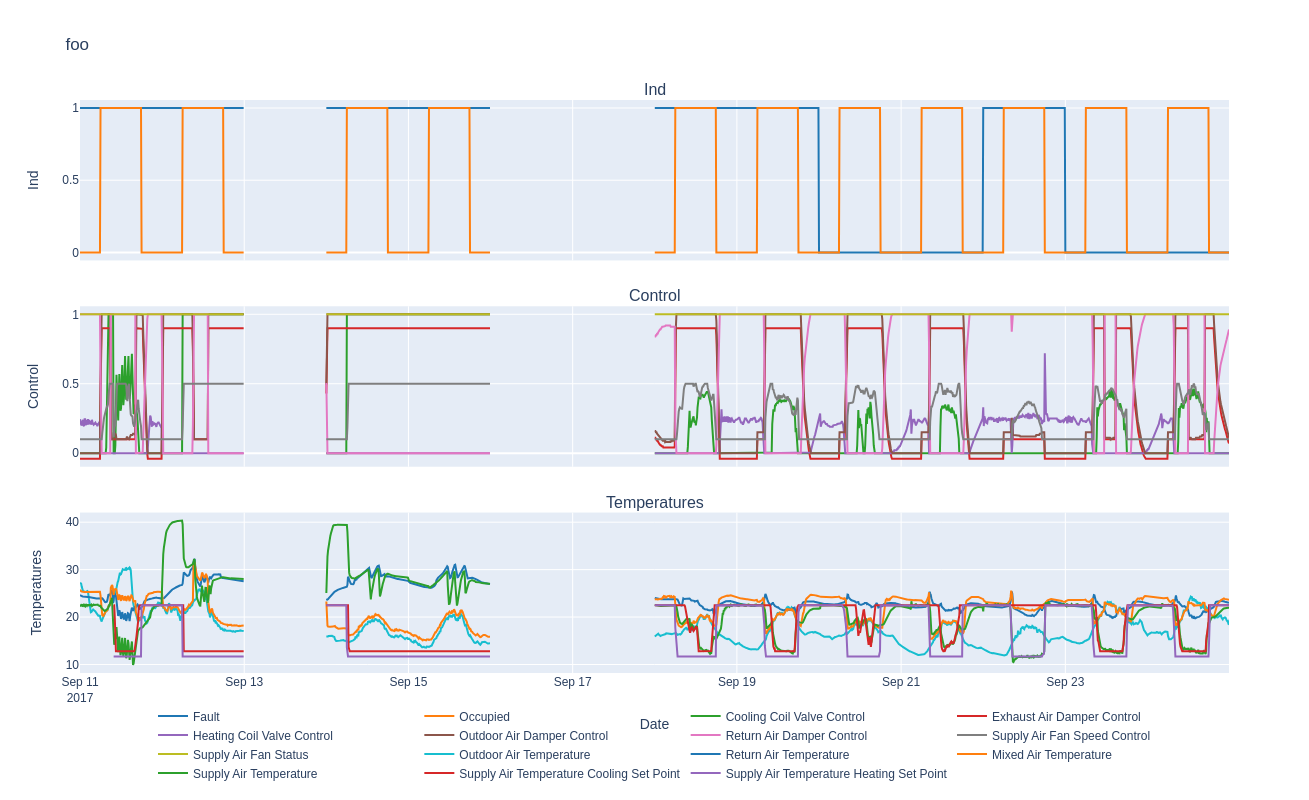

In [4]:

def plot_grouped_timeseries(df, date_col, groups, title="Grouped Time Series", 
                          height=None, colors=None, show_legend=True):

    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    import pandas as pd
    import numpy as np

    if height is None:
        height = 200 * len(groups) + 100
    
    # Create subplots
    fig = make_subplots(
        rows=len(groups),
        cols=1,
        subplot_titles=list(groups.keys()),
        vertical_spacing=0.08,
        shared_xaxes=True
    )
    
    # Default colors if not provided
    if colors is None:
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
                 '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    
    color_idx = 0

    df = df.sort_values(date_col)
    
    # Plot each group in its own subplot
    for i, (group_name, columns) in enumerate(groups.items(), 1):
        for col in columns:
            #print(df[col])
            #print()
            y_data = [ float(d) for d in df[col].copy() ] # XXX: no idea why have to convert to floats
            times = df[date_col].values
            fig.add_trace(
                go.Scatter(
                    x=times,
                    y=y_data,
                    mode='lines',
                    #mode='markers',
                    marker=dict(size=3.0),
                    name=col,
                    #legendgroup=group_name,
                    showlegend=show_legend,
                    line=dict(color=colors[color_idx % len(colors)]),
                    #connectgaps=False,
                ),
                row=i, col=1
            )
            color_idx += 1
    
    # Update layout
    fig.update_layout(
        title=title,
        height=height,
        hovermode='x unified',
        legend=dict(
            orientation="v",
            yanchor="top",
            y=1,
            xanchor="left",
            x=1.02
        ) if show_legend else None
    )
    
    # Update axes
    fig.update_xaxes(title_text="Date", row=len(groups), col=1)
    
    for i, group_name in enumerate(groups.keys(), 1):
        fig.update_yaxes(title_text=f"{group_name}", row=i, col=1)
        pass


    # Move legend to bottom center
    fig.update_layout(
        legend=dict(
            orientation='h',      # horizontal layout
            yanchor='bottom',
            y=-0.2,               # adjust this to move further down
            xanchor='center',
            x=0.5
        )
    )
    
    return fig


indicators = [
    'Fault',
    'Occupied',
]
control = [
    'Cooling Coil Valve Control',
    'Exhaust Air Damper Control',
    'Heating Coil Valve Control',
    'Outdoor Air Damper Control',
    'Return Air Damper Control',
    'Supply Air Fan Speed Control',
    'Supply Air Fan Status',
]
temperatures = [
    'Outdoor Air Temperature',
    'Return Air Temperature',
    'Mixed Air Temperature',
    'Supply Air Temperature',
    'Supply Air Temperature Cooling Set Point',
    'Supply Air Temperature Heating Set Point',
]

# Define groups
groups = {
    'Ind': indicators,
    'Control': control,
    'Temperatures': temperatures,
}

# Create the plot
fig = plot_grouped_timeseries(
    df=df.reset_index(),
    date_col='Time',
    groups=groups,
    title='foo',
    height=800
)
fig.show()

In [6]:
from arimax import ARIMAXAnomalyDetector


In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def anomaly_detect_period(model,
                          X_train, y_train, timestamps_train,
                          X_test, y_test, timestamps_test):
    
    model.fit(y_train, X_train, timestamps_train)
    
    # Detect anomalies on test data
    predictions = pandas.Series(model.predict(X=X_test, timestamps=timestamps_test))
 
    # Calculate performance metrics on aligned data
    valid_mask = ~(y_test.isna() | predictions.isna())
    y_test_aligned = y_test[valid_mask]
    predictions_aligned = predictions[valid_mask]
    timestamps_aligned = timestamps_test[valid_mask]

    pred = pandas.DataFrame({
        'time': timestamps_aligned,
        'prediction': predictions_aligned,
        'input': y_test_aligned,
    })
    # TODO: also include train data, for diagnostics
    return pred
    

def smape(y_true, y_pred):
    """Symmetric Mean Absolute Percentage Error"""
    np = numpy
    return 100 * np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred)))

def anomaly_detection(data, target, make_detector, covariates=[],
                      lookback='5d', predict='4h', hop='1h'):
    
    assert isinstance(data.index, pandas.DatetimeIndex), type(data.index)
    assert df.index.is_monotonic_increasing

    hop = pandas.Timedelta(hop)
    predict = pandas.Timedelta(predict)
    lookback = pandas.Timedelta(lookback)
    
    # Determine periods
    data_start = data.index.min()
    data_end = data.index.max()
    output_start = data_start + lookback
    output_end = data_end

    periods = pandas.date_range(output_start, output_end, freq=hop)
    #print(periods)
    print(data_start, data_end, hop, len(periods))
    
    # For each period, do forecasting and anomaly scoring
    outputs = []
    models = []
    for predict_start in periods:
        predict_end = predict_start + predict
        train_start = predict_start - lookback
        train_end = predict_start
        assert train_start >= data_start

        train_data = data.loc[train_start:train_end]
        test_data = data.loc[predict_start:predict_end]

        model = make_detector()
        pred = anomaly_detect_period(model,
                              train_data[covariates], train_data[target], train_data.index,
                              test_data[covariates], test_data[target], test_data.index,
        ) 
        pred['period'] = predict_start
        models.append(model)
        outputs.append(pred)

    out = pandas.concat(outputs)
    
    def score_period(df):
        s = smape(y_true, y_pred)
        pass
        
    # TODO: aggregate and compute anomaly scores
    aggregated = out.groupby('time').agg('median', numeric_only=True)

    coefficients = pandas.DataFrame([ dict(zip(m.feature_names_, m.model.coef_)) for m in models ])
    coefficients['time'] = periods
    coefficients = coefficients.set_index('time')
    
    return aggregated, coefficients


def make_detector():
    seasonal_period = int(pandas.Timedelta(hours=1*24 ) / df.index.freq)

    import elastic_net_linear as enl
    regression = enl.ElasticNetRegression(alpha=0.01, l1_ratio=0.5, max_iterations=1000, verbose=False)

    from sklearn.linear_model import LinearRegression, ElasticNet
    #regression = LinearRegression()
    #regression = ElasticNet(alpha=0.01, l1_ratio=0.5, max_iter=1000)
    
    detector = ARIMAXAnomalyDetector(
        ar_order=1,
        ma_order=1,
        # Penalizing the AR/MA terms is often neccesary to get covariates to matter at all
        ma_penalty=0.2,
        ar_penalty=0.2,
        diff_order=0,
        seasonal_ar=0,
        seasonal_ma=1,
        seasonal_period=seasonal_period,
        anomaly_threshold=3.0,
        regression_model=regression,
        #time_features=[],
        time_features=['hour'],
    )

    return detector

def add_scores(df, out):
    with_scores = pandas.merge(df, out, left_index=True, right_index=True)
    with_scores['difference'] = with_scores['input'] - with_scores['prediction']
    with_scores['difference_abs'] = with_scores['difference'].abs()
    with_scores.index.name = 'Time'
    
    from scorer import GammaAnomalyTransformer, HalfNormAnomalyTransformer
    transformer = HalfNormAnomalyTransformer(severity_factor=0.2)
    
    #transformer = GammaAnomalyTransformer(use_log=False, severity_factor=1.3)
    transformer.fit(1.0*with_scores.difference.abs())
    scores = transformer.transform(with_scores.difference.abs())
    with_scores['anomaly_score'] = scores
    with_scores.head()
    return with_scores

def make_plotting_config(target, covariates, other=[]):

    possible = covariates + other
    temperatures = [ c for c in possible if 'Temperature' in c ]
    controls = [ c for c in possible if 'Control' in c or 'Occupied' in c ]

    groups = {
        'Target': [ target ] + ['input', 'prediction'],
        'Difference': ['difference', 'difference_abs'],
        'Anomaly': ['anomaly_score', 'Fault'],
    }
    if controls:
        groups['Control'] = controls
    if temperatures:
        groups['Temperatures'] =  temperatures
    return groups



def anomaly_detect_config(df, config):

    plot_groups = make_plotting_config(one['target'], one['covariates'], config.get('related', []))
    out, coefficients = anomaly_detection(df, make_detector=make_detector, target=config['target'], covariates=config['covariates'])
    scores = add_scores(df, out)

    # Create the plot
    fig = plot_grouped_timeseries(
        df=scores.reset_index(),
        date_col='Time',
        groups=plot_groups,
        title=config.get('name', ''),
        height=800
    )
    
    return fig, scores, coefficients

one=dict(
    target = 'Supply Air Temperature',
    covariates = [
        #'Occupied',
        #'Outdoor Air Temperature',
        'Supply Air Temperature Heating Set Point',
    ],
    related = [],
)
fig, scores, coefficients = anomaly_detect_config(df, one)
fig.show()
coefficients.mean()

2017-09-11 00:00:00 2017-09-24 23:50:00 0 days 01:00:00 216


IndexError: Boolean index has wrong length: 26 instead of 25

In [8]:
one=dict(
    target = 'Heating Coil Valve Control',
    covariates = [
        'Occupied',
        'Outdoor Air Temperature',
        'Supply Air Temperature Heating Set Point',
    ],
    related = [],
)
fig, scores, coefficients = anomaly_detect_config(df, one)
fig.show()
coefficients.mean()

2017-09-11 00:00:00 2017-09-24 23:50:00 0 days 01:00:00 216


ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- sma_lag_1


In [ ]:

coefficients_groups = {
    'One': list(coefficients.columns),
}

# Create the plot
fig = plot_grouped_timeseries(
    df=coefficients.reset_index(),
    date_col='time',
    groups=coefficients_groups,
    title='cc',
    height=800
)

fig.show()



